## Twitter Sentiment Analysis: Project Pipeline

### Step-1: Import the Necessary Dependencies

In [2]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# import nltk
# nltk.download('wordnet')
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Step-2: Read and Load the Dataset

In [4]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
1219165,4,1989910387,Mon Jun 01 03:14:20 PDT 2009,NO_QUERY,jomuelquerido,just finished packing my things for tomorrow.....
1303004,4,2008966459,Tue Jun 02 14:56:25 PDT 2009,NO_QUERY,parker_anderson,"@michellearenz haha, no. It implys that we're ..."
731292,0,2263784759,Sun Jun 21 01:48:13 PDT 2009,NO_QUERY,itsamanda9,"Ok, the key to my front door that I just had c..."
257475,0,1984973240,Sun May 31 16:10:29 PDT 2009,NO_QUERY,emilywoloshyn,@taylorswift13 all i want to do is watch your ...
278115,0,1991451403,Mon Jun 01 07:03:48 PDT 2009,NO_QUERY,jc76,@steven_Collins I'm the last Collins in my lin...


### Step-3: Exploratory Data Analysis

#### 3.1: Five top records of data

In [5]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#### 3.2: Columns/features in data

In [6]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

#### 3.3: Length of the dataset

In [7]:
print('length of data is', len(df))

length of data is 1600000


#### 3.4: Shape of data

In [8]:
df. shape

(1600000, 6)

#### 3.5: Data information

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#### 3.6: Datatypes of all columns

In [10]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

#### 3.7: Checking for null values

In [11]:
np.sum(df.isnull().any(axis=1))

0

#### 3.8: Rows and columns in the dataset

In [12]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


#### 3.9: Check unique target values

In [13]:
df['target'].unique()

array([0, 4], dtype=int64)

#### 3.10: Check the number of target values

In [14]:
df['target'].nunique()

2

### Step-4: Data Visualization of Target Variables

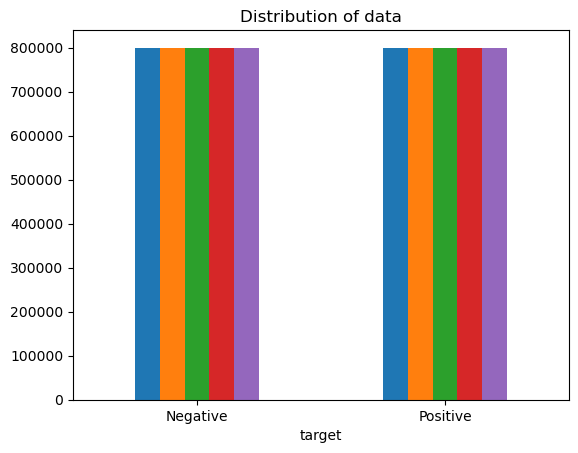

In [15]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

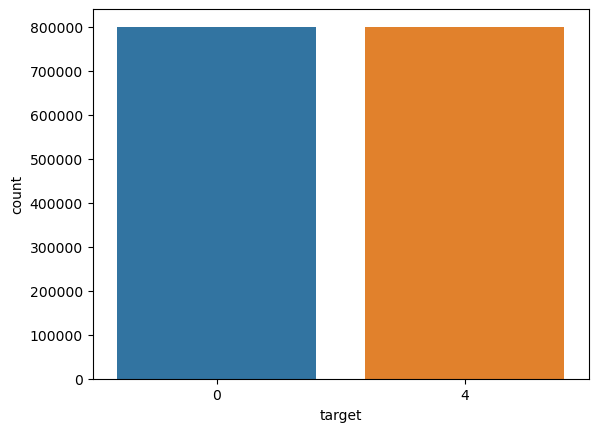

In [16]:
import seaborn as sns
sns.countplot(x='target', data=df)

### Step-5: Data Preprocessing

#### 5.1: Selecting the text and Target column for our further analysis

In [17]:
data=df[['text','target']]

#### 5.2: Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)

In [18]:
data['target'] = data['target'].replace(4,1)

C:\Users\Dell\AppData\Local\Temp\ipykernel_14912\2499609609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


#### 5.3: Printing unique values of target variables

In [19]:
data['target'].unique()

array([0, 1], dtype=int64)

#### 5.4: Separating positive and negative tweets

In [20]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

#### 5.5: Taking one-fourth of the data so we can run it on our machine easily

In [21]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

#### 5.6: Combining positive and negative tweets

In [22]:
dataset = pd.concat([data_pos, data_neg])

#### 5.7: Making statement text in lowercase

In [23]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

#### 5.8: Defining set containing all stopwords in English.

In [24]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

#### 5.9: Cleaning and removing the above stop words list from the tweet text

In [25]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

#### 5.10: Cleaning and removing punctuations

In [26]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

#### 5.11: Cleaning and removing repeating characters

In [27]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

#### 5.12: Cleaning and removing URLs

In [28]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

#### 5.13: Cleaning and removing numeric numbers

In [29]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

#### 5.14: Getting tokenization of tweet text

In [30]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()



800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

#### 5.15: Applying stemming

In [31]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

#### 5.16: Applying lemmatizer

In [32]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

#### 5.17: Separating input feature and label

In [33]:
X=data.text
y=data.target

#### 5.18: Plot a cloud of words for negative tweets

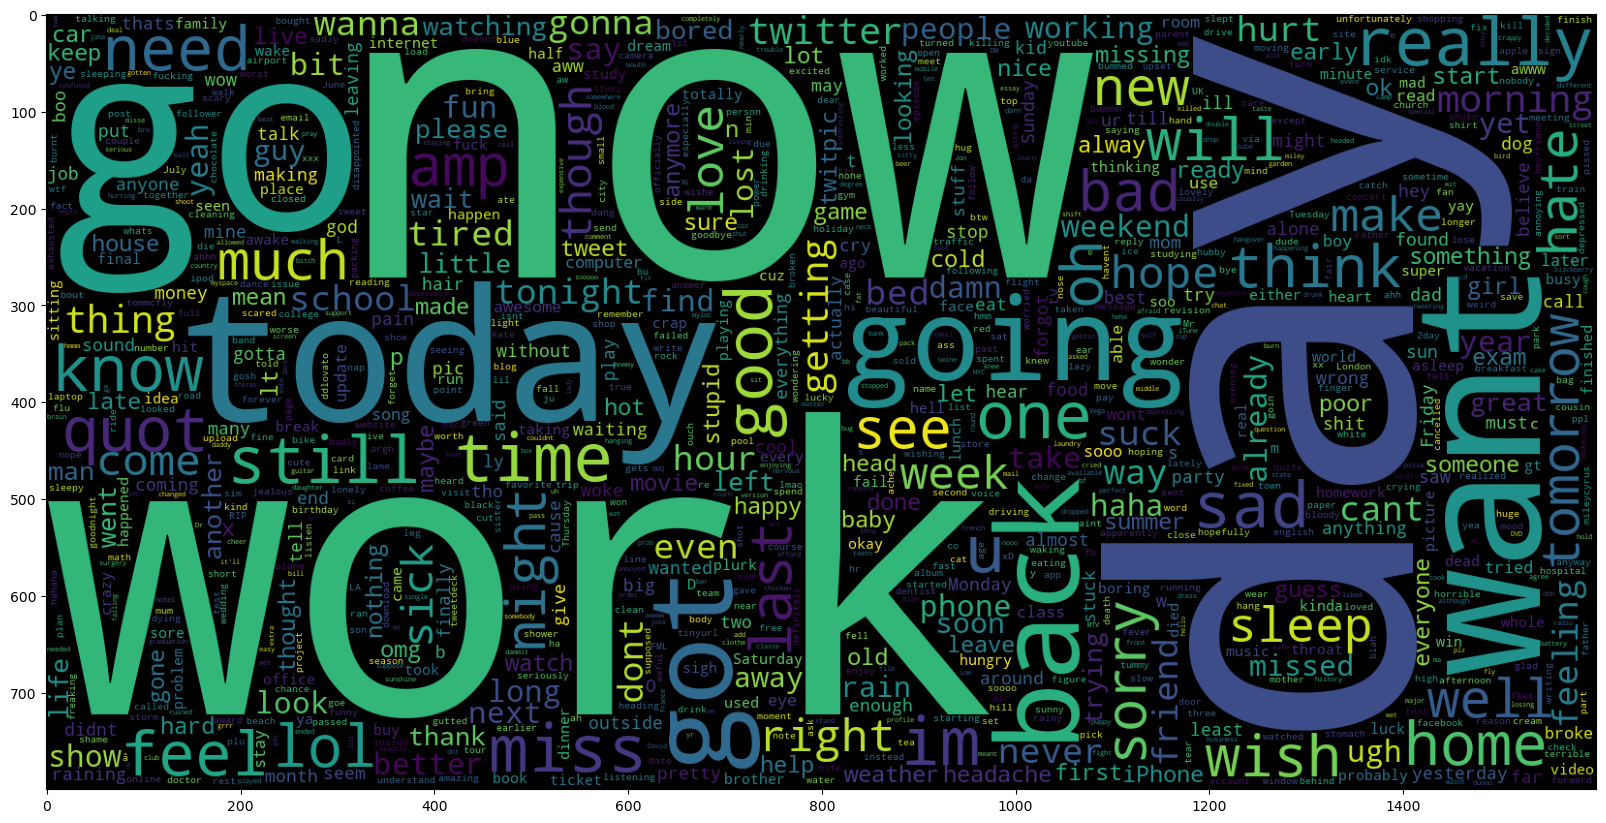

In [34]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

#### 5.19: Plot a cloud of words for positive tweets

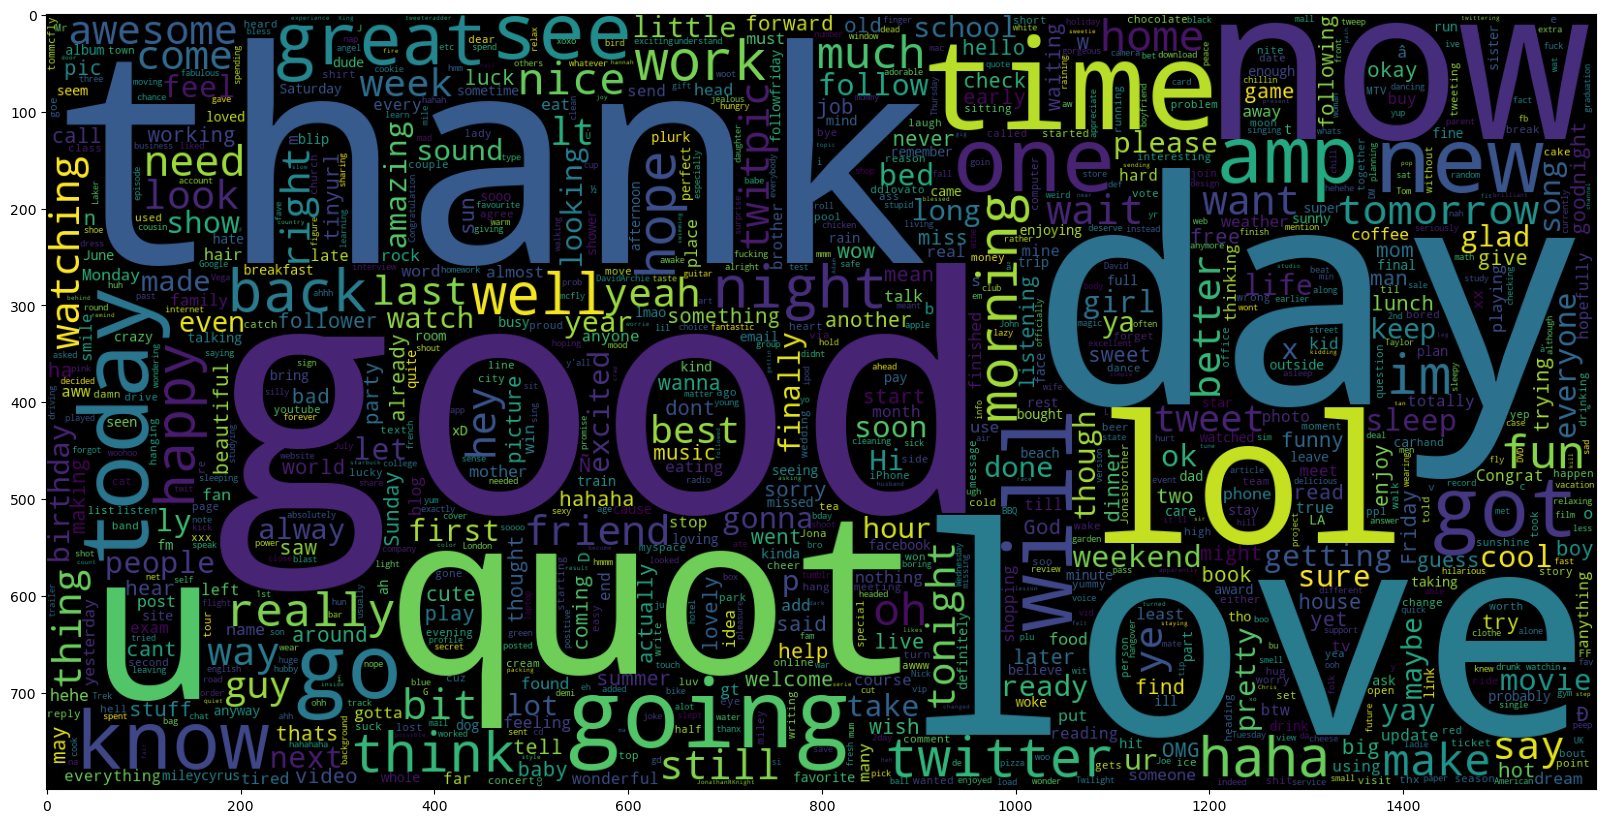

In [35]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

#### Step-6: Splitting Our Data Into Train and Test Subsets

In [36]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

### Step-7: Transforming the Dataset Using TF-IDF Vectorizer

#### 7.1: Fit the TF-IDF Vectorizer

In [37]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


#### 7.2: Transform the data using TF-IDF Vectorizer

In [38]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

#### Step-8: Function for Model Evaluation

In [39]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Step-9: Model Building

#### 8.1: Model-1

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



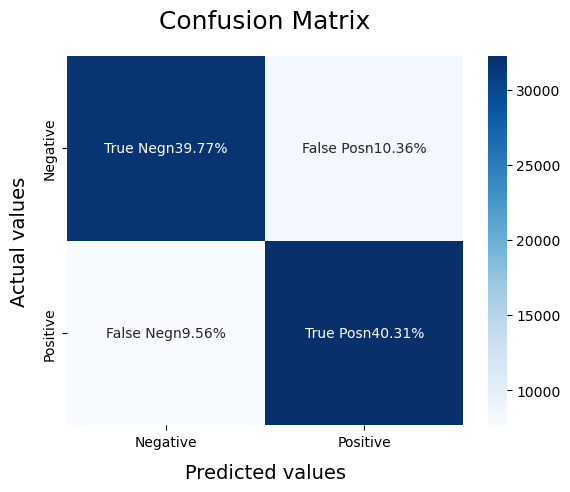

In [40]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

#### 8.2: Plot the ROC-AUC Curve for model-1

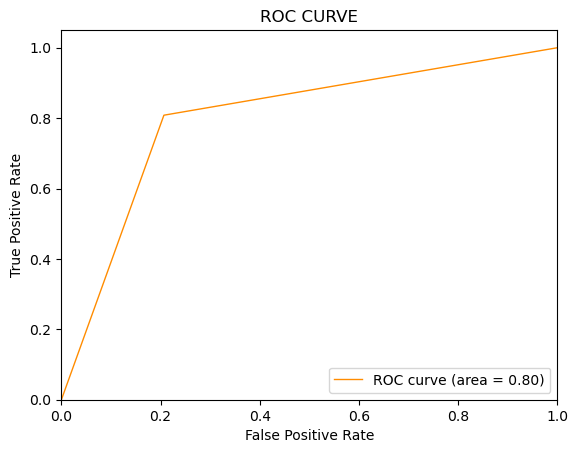

In [41]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### 8.3: Model-2:

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           1       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



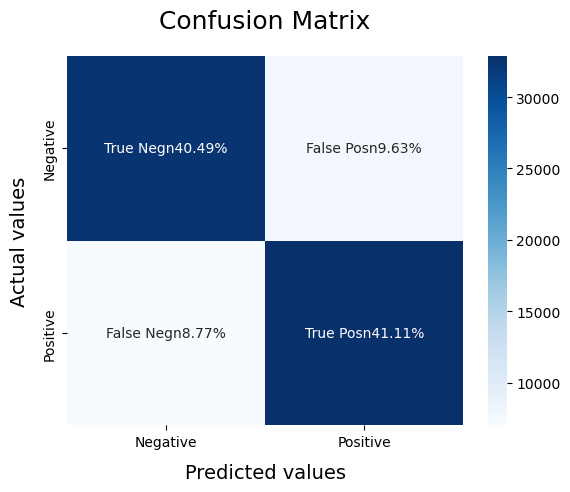

In [42]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

#### 8.4: Plot the ROC-AUC Curve for model-2

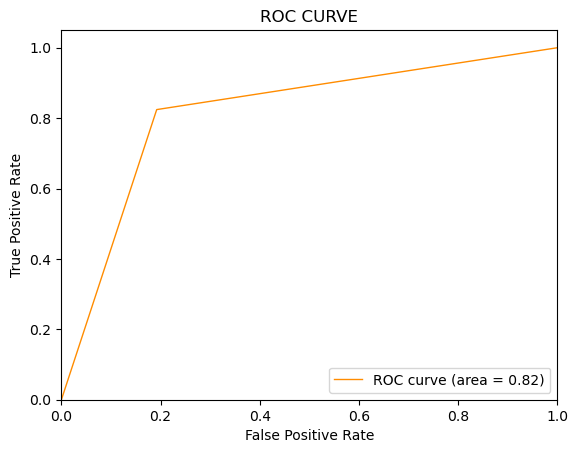

In [43]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### 8.5: Model-3

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



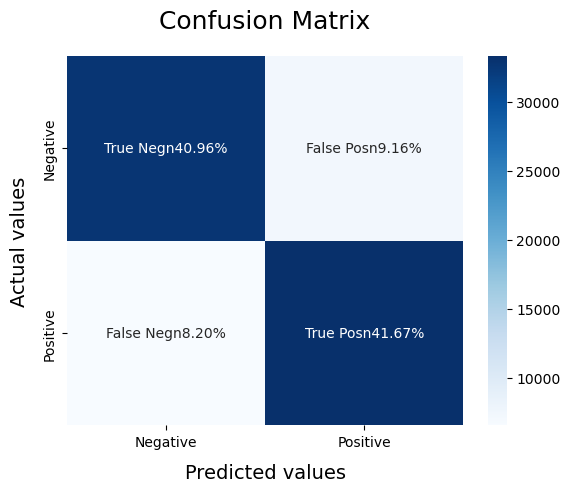

In [44]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

#### 8.6: Plot the ROC-AUC Curve for model-3

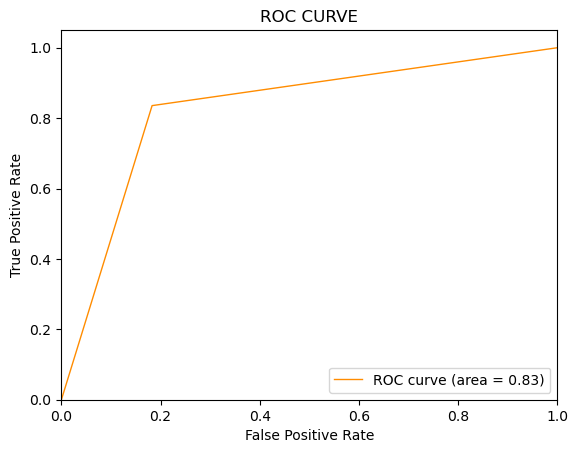

In [45]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Step-10: Model Evaluation

## Conclusion: